## Section 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

from spectral import *
from collections import Counter


In [2]:
# Read the spectral library using the spectral package
lib = envi.open('../data/UPWINS_spectral_library_6_25_2024.hdr')
#print(f'Number of spectra in libary: {len(lib.names)}')
#print(f'Number of bands in library: {len(lib.bands.centers)}')

# remove spectra with large derivate, which are the spectra collected using sunlight
derivitive = np.mean(np.abs(lib.spectra[:,1:]-lib.spectra[:,:-1]), axis=1)
select_indices = np.where(derivitive<0.0025)[0]
# create variables for the library data 
names = np.asarray(lib.names)[select_indices]
spectra = lib.spectra[select_indices,:]
wl = np.asarray(lib.bands.centers)
# create variables for the library metadata 
nSpec = len(names)
nBands = len(wl)

#print(' ')
#print('...remove spectra collected using outdoor solar illumination...')
#print(' ')
#print(f'Number of spectra: {nSpec}')
#print(f'Number of bands: {nBands}')

In [3]:
# read the metadata dataframe and extract the metadata as numpy arrays
df = pd.read_csv('../data/UPWINS_spectra_metadata_6_25_2024.csv', keep_default_na=False)
genus = []
species = []
principle_part = []
health = []
growth_stage = []
DateTimeId = []
month = []
plant_type = []
name = []
name_full_category = []
name_genus_species = []
select_indices = []
for i in range(len(names)):
    row = df.loc[df['ASD UPWINS base_fname'] == names[i]+'.asd']
    # if the spectrum has a corresponding row in the csv
    if (row['sub-category'].values[0] not in ['NA','backrounds']) & (row['category'].values[0] in ['vegetation','target_vegetation','soil','road']):
        select_indices.append(i)
        plant_type.append(row['sub-category'].values[0])
        genus.append(row['genus'].values[0])
        species.append(row['species'].values[0])
        principle_part.append(row['principal_part'].values[0])
        health.append(row['health'].values[0])
        growth_stage.append(row['growth_stage'].values[0])
        name_genus_species.append(row['genus'].values[0]+'_'+row['species'].values[0])
        DateTimeId.append(row['DateTimeUniqueIdentifier'].values[0])
        month.append(row['DateTimeUniqueIdentifier'].values[0][4:6])
        if row['genus'].values[0]=='NA':
            #not in our primary target vegetation library
            name.append(row['sub-category'].values[0])
            name_full_category.append(row['sub-category'].values[0]+'_'+row['principal_part'].values[0]+'_'+row['health'].values[0]+'_'+row['growth_stage'].values[0])
        else:
            name.append(row['genus'].values[0]+'_'+row['species'].values[0])
            name_full_category.append(row['genus'].values[0]+'_'+row['species'].values[0]+'_'+row['principal_part'].values[0]+'_'+row['health'].values[0]+'_'+row['growth_stage'].values[0])

names = np.asarray(lib.names)[select_indices]
spectra = spectra[select_indices,:]
# create variables for the library metadata 
nSpec = len(names)
nBands = len(wl)

#print(f'Number of spectra: {nSpec}')
#print(f'Number of bands: {nBands}')

Number of spectra: **`{python} nSpec`**

Number of bands: **`{python} nBands`**

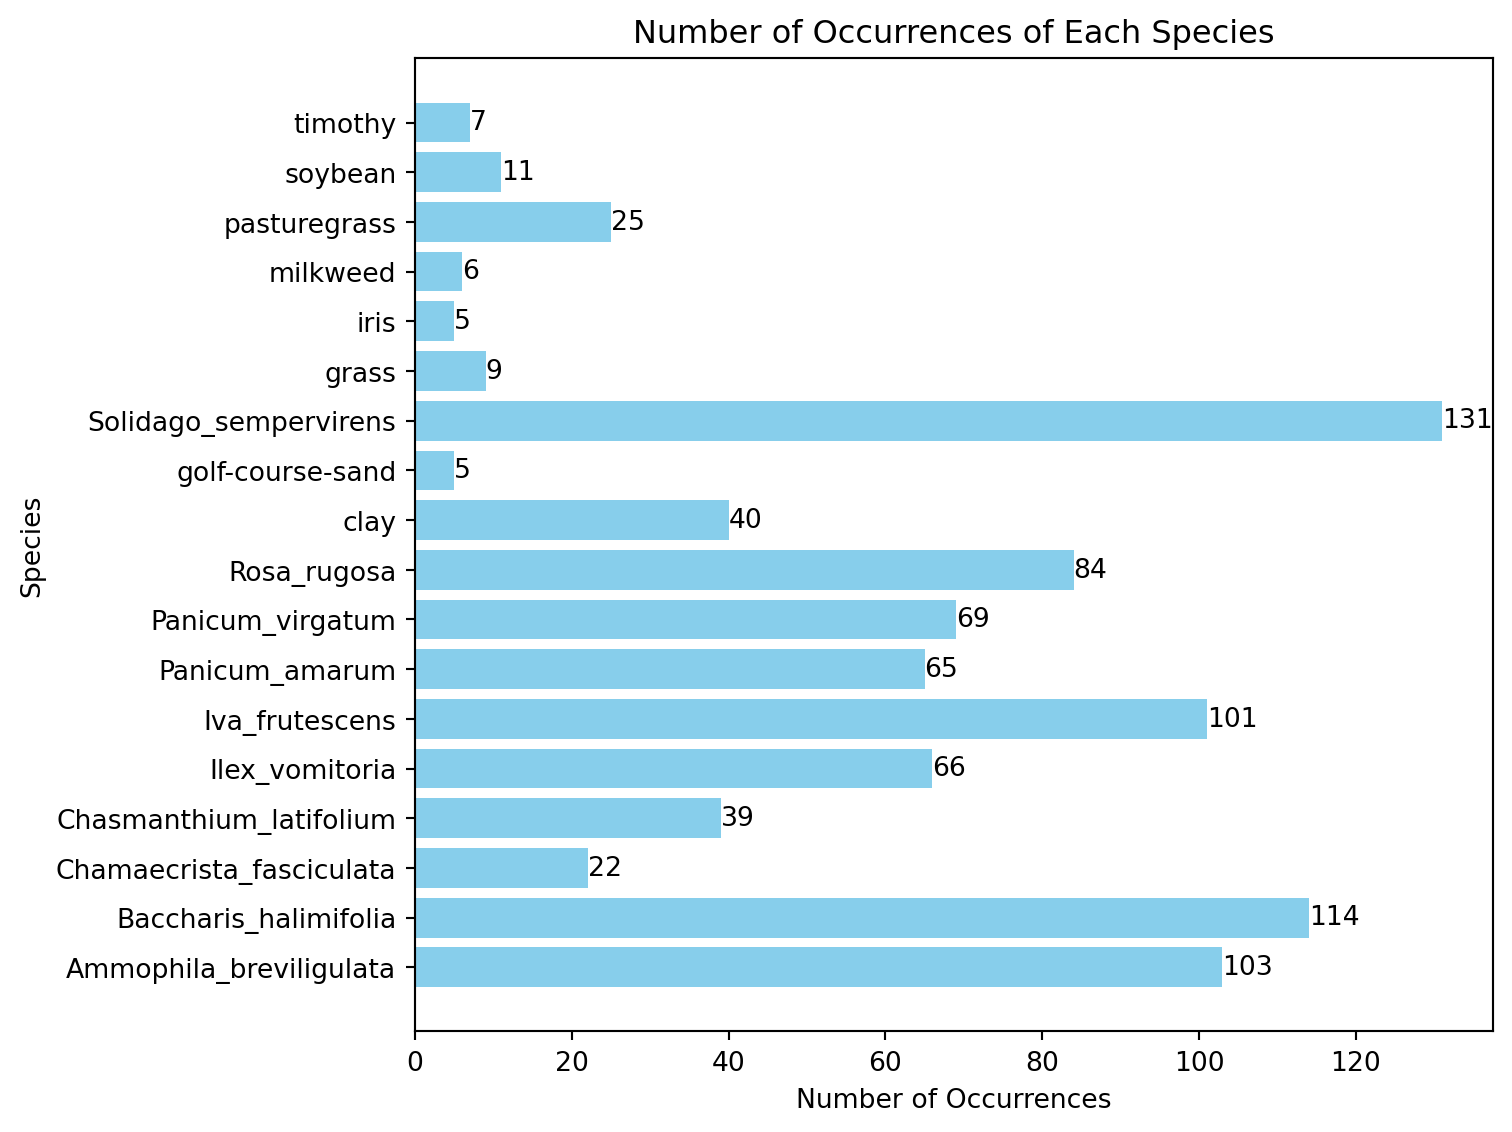

In [4]:
#| label: fig-label
#| fig-cap: Number of Occurrences

# Count the occurrences of each unique value
name_counts = Counter(name)
# Extract the labels and values
labels, values = zip(*name_counts.items())
# Create the horizontal bar plot
plt.figure(figsize=(8, 6))
bars = plt.barh(labels, values, color='skyblue')
# Add text labels on the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, str(value), ha='left', va='center')
# Set the labels and title
plt.ylabel('Species')
plt.xlabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Species')
plt.tight_layout()
plt.show()

## Section 2

In [5]:
def set_color(x, colormap_name = 'tab20'):
    # This function returns a dictionary of colors based on the input numpy x of metadata values
    # The default colormap is tab10 (tableau 10), but any named colormap can be used
    categories = np.unique(x)
    if colormap_name == 'health':
        clr = {'D': 'orange',
               'H': 'green',
               'LLRZ': 'gold',
               'MX': 'olive',
               'NA': 'gray',
               'R': 'red',
               'S': 'goldenrod',
               }
        
    else:
        if colormap_name == 'custom':
            color_list = ['r','g','b','c','m','y','maroon','orange',
                'darkgreen','lime','navy','teal',
                'indigo','crimson','pink','slategrey',
                'darkgoldenrod','purple']
            clr = {}
            for i,category in enumerate(categories):
                clr[category] = color_list[i]
        else:
            clr = {}
            cmap = matplotlib.colormaps.get_cmap(colormap_name)
            for i,category in enumerate(categories):
                clr[category] = cmap(i/len(categories))
    return clr 

In [6]:
name = np.asarray(name)
clr_n = set_color(name)

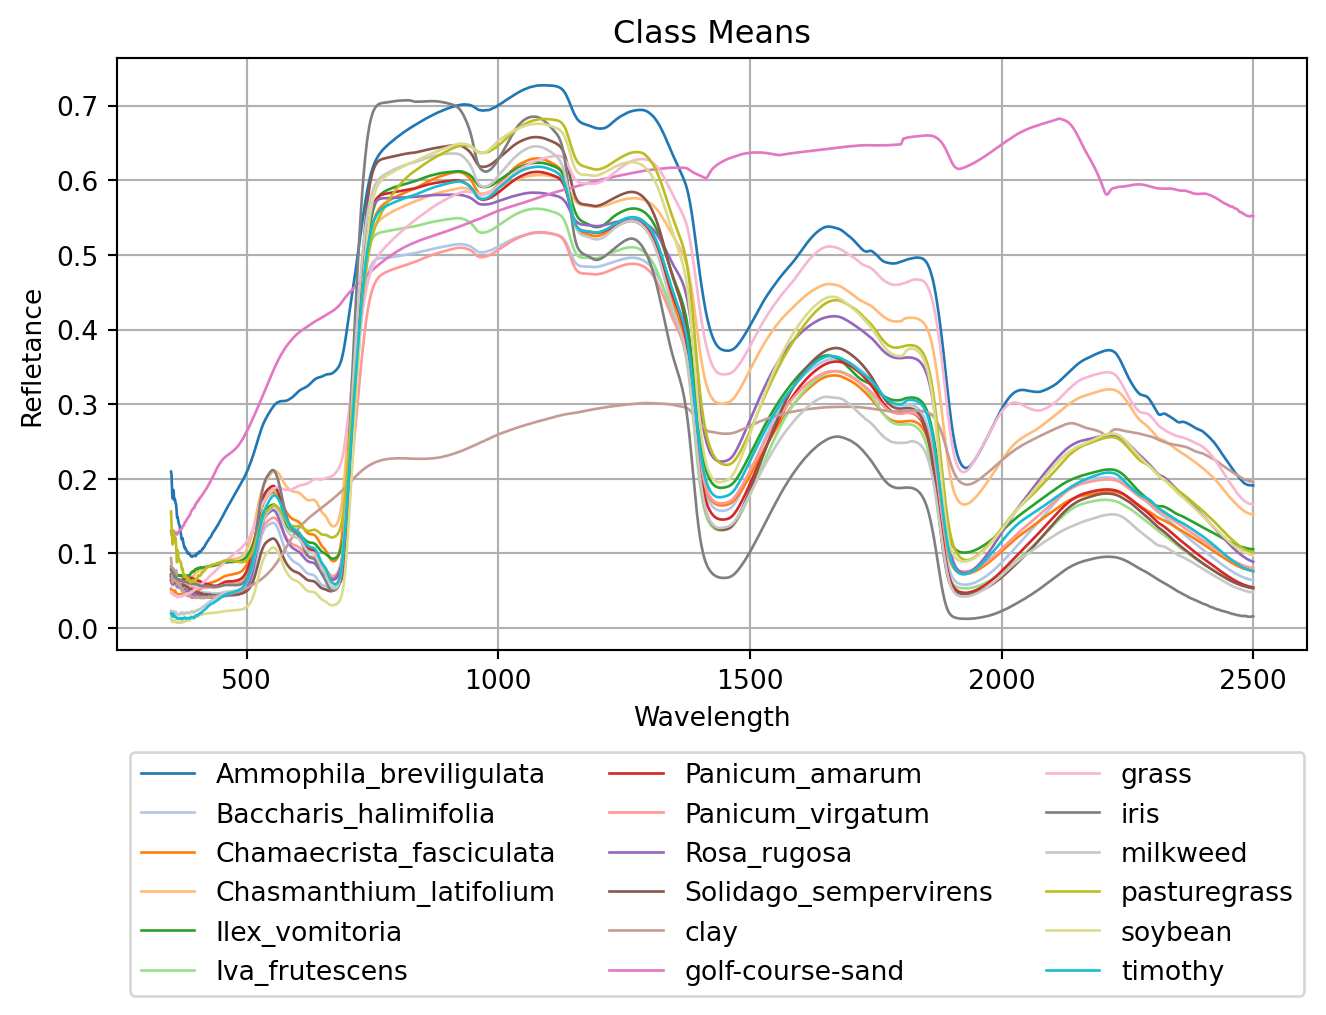

In [7]:
#| label: fig-label2
#| fig-cap: Class Means

# plot the mean of each class
plt.figure(figsize=(8,4))
plt.grid(True)
for n in np.unique(name):
    idx = np.where(name==n)[0]
    mean_spectrum = np.mean(spectra[idx,:], axis=0)
    plt.plot(wl, mean_spectrum, label=n, lw=1, c=clr_n[n])
plt.xlabel('Wavelength')
plt.ylabel('Refletance')
plt.title('Class Means')
plt.legend(bbox_to_anchor=(0.0, -0.15), ncols=3, loc='upper left')